In [ ]:
import os
import numpy as np
import tensorflow as tf
import shutil
import glob as glob
import cv2
import matplotlib.pyplot as plt
import random
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/mu2mech_final_data_10.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_90.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_100.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_110.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_120.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_130.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_140.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_150.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_160.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_170.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_180.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_190.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_200.00.png  
  

In [ ]:
model = load_model("/content/drive/MyDrive/New_models_Mu2Mech/5th_time_step/Reconstruction_model_3/autoencoder.hdf5")
layer_name = 'max_pooling2d_2'
encoder = tf.keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
layer_name = 'conv2d_6'
decoder = tf.keras.Model(inputs=encoder.output,outputs=model.get_layer(layer_name).output)


# ConvLSTM

In [ ]:
# Input for ConvLSTM

compositions = ['0.25%', '0.3%', '0.33%', '0.35%','0.37%', '0.4%', '0.43%', '0.45%', '0.47%', '0.5%']
train_images = []
from tkinter import Tcl
from PIL import Image

for i in range(0,10):
 comp = compositions[i]
 X = glob.glob("/content/mu2mech_final_data/5time_step/"+comp+"/*.png")
 X_sorted = Tcl().call('lsort', '-dict', X)
 print(len(X_sorted))
#  train_images = []

 for i,path in enumerate(X_sorted[1:]):
  image = cv2.imread(X_sorted[i])
  img = np.array(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype("float32") / 255
  train_images.append(img)

print(len(train_images))
# 1k images

# Converting to a numpy array
train_images = np.array(train_images)
print(train_images.shape)

X_train = train_images
print(X_train.shape)

# Inputs for the ConvLSTM
encoded_images = encoder.predict(X_train)

print(encoded_images.shape)

convlstm_input = []

for i in range(0,9960):
  temp = encoded_images[i:i+40,...]
  convlstm_input.append(temp)

convlstm_input = np.array(convlstm_input)

# Input is a 5D array - (samples, time_steps, H,W,filters)
convlstm_input.shape

# Inputs for the ConvLSTM model
X = convlstm_input

# Y will be the current 40 frames + 1st image
Y = encoded_images[40:,...]

print(X.shape)
print(Y.shape)



1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
10000
(10000, 128, 128, 3)
(10000, 128, 128, 3)
313/313 [==============================] - 8s 5ms/step
(10000, 16, 16, 4)
(9960, 40, 16, 16, 4)
(9960, 16, 16, 4)


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Construct the input layer with no definite frame size.
inp = tf.keras.layers.Input(shape=(None, *X.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.

x = tf.keras.layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(inp)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ConvLSTM2D(
    filters=8,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=False,
    activation="tanh",
)(x)

x = tf.keras.layers.Conv2D(
     filters=4, kernel_size=(3, 3), activation="relu", padding="same"
)(x)

# Next, we will build the complete model and compile it.
lstm_model = tf.keras.models.Model(inp, x)


In [ ]:
lstm_model.compile(
    loss='mse', optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy']
)
lstm_model.summary()

# Define some callbacks to improve training.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 8

checkpoint_filepath = '/content/drive/MyDrive/New_models_Mu2Mech/5th_time_step/ConvLSTM_2/lstm_model_5.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Splitting into train and validation
size = int(0.9*len(X))

#Training set
X_train = X[:size,...]
# Y = np.expand_dims(Y, axis=1)
y_train = Y[:size,...]

# X_val will be the images
X_val = X[size:,...]
# Y will be current training image + 1
y_val = Y[size:,...]

print(X_val.shape)
print(y_val.shape)
print(X_train.shape)
print(y_train.shape)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 16, 16, 4)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 16, 16, 16)  32064     
                                                                 
 batch_normalization (BatchN  (None, None, 16, 16, 16)  64       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 16, 16, 8)         800       
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 4)         292       
                                                                 
Total params: 33,220
Trainable params: 33,188
Non-trainable

In [ ]:

# Fit the model to the training data.
lstm_model.fit(
    X_train[0:5000],
    y_train[0:5000],
    batch_size=8,
    epochs=epochs,
    validation_data = (X_val,y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint_callback],
)


Epoch 1/50
625/625 [==============================] - 131s 197ms/step - loss: 0.0064 - accuracy: 0.9453 - val_loss: 0.0070 - val_accuracy: 0.9361 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 112s 180ms/step - loss: 0.0010 - accuracy: 0.9754 - val_loss: 0.0018 - val_accuracy: 0.9486 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 116s 185ms/step - loss: 7.2014e-04 - accuracy: 0.9793 - val_loss: 0.0014 - val_accuracy: 0.9584 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 113s 180ms/step - loss: 5.8430e-04 - accuracy: 0.9814 - val_loss: 0.0012 - val_accuracy: 0.9651 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 111s 178ms/step - loss: 4.9849e-04 - accuracy: 0.9829 - val_loss: 0.0011 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 117s 188ms/step - loss: 4.4719e-04 - accuracy: 0.9839 - val_loss: 8.4647e-04 - val_accuracy: 0.9676 - lr: 0.0010
Epoch 7/50
625/625 [======

In [ ]:
preds = lstm_model.predict(X_val)

32/32 [==============================] - 3s 80ms/step


In [ ]:
predicted_img = decoder.predict(preds)

32/32 [==============================] - 0s 7ms/step


In [ ]:
#Make a separate Y_val for comparing the predicted images
Y_original = train_images[40:]
# Y_original = Y_original.astype('float32')/255.0
Y_val_original =  Y_original[8964:]
Y_val_original.shape


(996, 128, 128, 3)

In [ ]:
Y_val = np.array(Y_val_original)

In [ ]:
score = lstm_model.evaluate(predicted_img[0], Y_val_original[0])

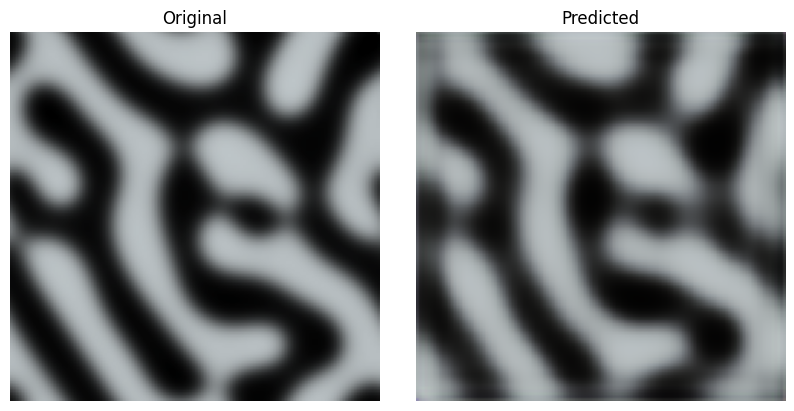

In [ ]:
import matplotlib.pyplot as plt

# Load the 41st first image
image_1 = Y_val_original[100]

# Load the 41st predicted image
image_2 =  predicted_img[99]

# Create a figure and subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,8))

# Plot the first image in the first subplot
axes[0].imshow(image_1)
axes[0].set_title("Original")

# Plot the second image in the second subplot
axes[1].imshow(image_2)
axes[1].set_title("Predicted")

# Remove the ticks and labels
for ax in axes:
    ax.axis("off")

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Show the figure
plt.show()
